In [3]:
import platform
import os
import psutil

print("Sistema operatiu:", platform.system(), platform.release())
print("Processador:", platform.processor())
print("CPU físics:", psutil.cpu_count(logical=False))
print("CPU lògics:", psutil.cpu_count())
print("RAM total (GB):", round(psutil.virtual_memory().total / (1024 ** 3), 2))

Sistema operatiu: Linux 6.1.123+
Processador: x86_64
CPU físics: 1
CPU lògics: 2
RAM total (GB): 12.67


In [ ]:
import pandas as pd

EVO = pd.read_csv('/data/EVO.csv')

In [5]:
EVO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61368 entries, 0 to 61367
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dia               61368 non-null  object 
 1   Tm                61355 non-null  float64
 2   Tmax              61363 non-null  float64
 3   Tmin              61364 non-null  float64
 4   Velocitat_vent    61368 non-null  float64
 5   HRmd              61356 non-null  float64
 6   HRmax             61363 non-null  float64
 7   Precipitacio      61368 non-null  float64
 8   Irradiacio_solar  61361 non-null  float64
 9   ETo               61216 non-null  float64
 10  Clima             61368 non-null  object 
 11  Lat               61368 non-null  float64
 12  EMA               61368 non-null  object 
 13  Any               61368 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 6.6+ MB


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os
import random

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

df = EVO

df['Dia'] = pd.to_datetime(EVO['Dia'])
df['D'] = df['Dia'].dt.dayofyear


# Creació variable dia en ciclica
df['Dia_sin'] = np.sin(2 * np.pi * df['D'] / 365.0)
df['Dia_cos'] = np.cos(2 * np.pi * df['D'] / 365.0)


# Eliminació nulls. Segureta.
df = df[['Tm', 'Tmax','Tmin','Irradiacio_solar', 'D', 'Clima', 'ETo', 'Lat', 'EMA', 'Dia_sin', 'Dia_cos']].dropna()

# Codificació varaible categorica tipus de clima
le_clima = LabelEncoder()
df['Clima_enc'] = le_clima.fit_transform(df['Clima'])
num_classes_clima = len(np.unique(df['Clima_enc']))

# Classificació variables segons tipus
X_num = df[['Tm','Tmax','Tmin', 'Lat', 'Dia_sin', 'Dia_cos']].values
X_clima = df['Clima_enc'].values
# Varaible dia només es classifica per calcular posteriorme el valor de Ra.
# No s'inclourà al calcul del model.
X_d = df['D'].values
y = df['ETo'].values

# Confecció conjunts de teste i entrenament
X_num_train, X_num_test, X_clima_train, X_clima_test, X_d_train, X_d_test, y_train, y_test = train_test_split(
    X_num, X_clima, X_d, y, test_size=0.2, random_state=SEED
)

In [ ]:
# Escalat numèrqies
scaler_num = StandardScaler().fit(X_num_train)
X_num_train_scaled = scaler_num.transform(X_num_train)
X_num_test_scaled = scaler_num.transform(X_num_test)

# Escalat 0,1 per Evo
scaler_y = MinMaxScaler().fit(y_train.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [ ]:
# Formula Radiacio. font: Recomanador Gemini
def calcular_Ra(latitud_graus, dia_any):
    # Convertir latitud a radians
    phi = np.radians(latitud_graus)
    # Dia de l'any a radians
    J = dia_any
    # Constant solar (MJ/m²/min)
    Gsc = 0.0820
    # Calcular paràmetres astronòmics
    dr = 1 + 0.033 * np.cos(2 * np.pi / 365 * J) # Distància relativa Terra-Sol
    delta = 0.409 * np.sin(2 * np.pi / 365 * J - 1.39) # Declinació solar (radians)
    # Angle solar horari a la posta de sol (radians)
    # Cal anar amb compte amb valors fora de [-1, 1] per a arccos en zones polars
    cos_ws_arg = -np.tan(phi) * np.tan(delta)
    cos_ws_arg = np.clip(cos_ws_arg, -1.0, 1.0) # Assegura estar dins del rang
    ws = np.arccos(cos_ws_arg)
    # Calcular Ra (MJ/m²/dia) - Fórmula FAO-56 Eq. 21
    Ra = (24 * 60 / np.pi) * Gsc * dr * (ws * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(ws))

    return np.maximum(Ra, 0.0)

In [9]:
# Fórmula Hargreaves–Samani simplificada
def et0_hargreaves(Tm, Tmax, Tmin, Ra, C=0.0020, a=17.8, b=0.1726):
    TR = np.maximum(Tmax - Tmin, 0.0)

    # Fórmula HS
    ETo_HS = C * Ra * (Tm + a) * np.power(TR, b)

    return np.maximum(ETo_HS, 0.0)

In [10]:
# Extracció valors per calcul de Ra i Evo. Valors no escalats
Tm_train_orig = X_num_train[:, 0]
Tmax_train_orig = X_num_train[:, 1]
Tmin_train_orig = X_num_train[:, 2]
Lat_train_orig = X_num_train[:, 3]


Tm_test_orig = X_num_test[:, 0]
Tmax_test_orig = X_num_test[:, 1]
Tmin_test_orig = X_num_test[:, 2]
Lat_test_orig = X_num_test[:, 3]


In [11]:
# Aplicació formula calcul Ra
Ra_train = calcular_Ra(Lat_train_orig, X_d_train)
Ra_test = calcular_Ra(Lat_test_orig, X_d_test)

In [12]:
# Aplicació formula Hargreaves–Samani
ET0_HS_train_orig = et0_hargreaves(Tm_train_orig, Tmax_train_orig, Tmin_train_orig, Ra_train)
ET0_HS_test_orig = et0_hargreaves(Tm_test_orig, Tmax_test_orig, Tmin_test_orig, Ra_test)

# Escalat de valors Eto calculats amb la formula física
ET0_HS_train_orig_scaled = scaler_y.transform(ET0_HS_train_orig.reshape(-1, 1))
ET0_HS_test_orig_scaled = scaler_y.transform(ET0_HS_test_orig.reshape(-1, 1))

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

# Optimització paràmetres funció Hargreaves–Samani. Minimize

def objective_function(params, Tm, Tmax, Tmin, Ra, ETo_observada, a_fijo=17.8):
    b, C = params
    ETo_calculada = et0_hargreaves(Tm, Tmax, Tmin, Ra, a=a_fijo, b=b, C=C)
    mse = mean_squared_error(ETo_observada, ETo_calculada)
    return mse

# Optimización
initial_guess = [17, 0.5]  # Valores iniciales para a y b
result = minimize(objective_function, initial_guess,
                  args=(Tm_train_orig, Tmax_train_orig, Tmin_train_orig, Ra_train, y_train, 17.8),
                  method='L-BFGS-B', bounds=[(0, None), (0.002, 0.003)])

# Resultats
optimal_a, optimal_b = result.x
print(f"Valores óptimos: a = {optimal_a:.4f}, C = {optimal_b:.4f}")

Valores óptimos: a = 0.1726, C = 0.0020


In [ ]:
# Valors per model físic sobre volrs reals

R, p_value = pearsonr(y_train, ET0_HS_train_orig)


# Calcular el Mean Squared Error (MSE)
mse = mean_squared_error(y_train, ET0_HS_train_orig)

# Calcular el Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Pearson R (train): {R:.4f} (p‑value = {p_value:.2e})")
print(f"El valor de RMSE es: {rmse:.4f}")


Pearson R (train): 0.9287 (p‑value = 0.00e+00)
El valor de RMSE es: 0.6645


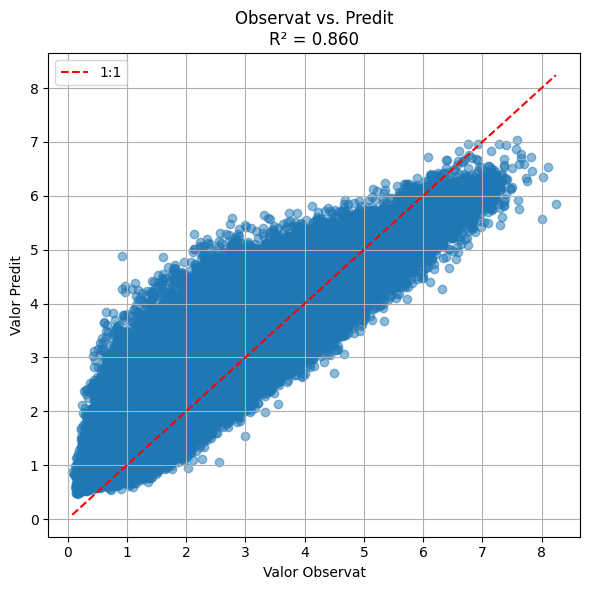

In [15]:
import matplotlib.pyplot as plt

# Gràfic models física

plt.figure(figsize=(6, 6))
plt.scatter(y_train, ET0_HS_train_orig, alpha=0.5)

minv = min(y_train.min(), ET0_HS_train_orig.min())
maxv = max(y_train.max(), ET0_HS_train_orig.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', label='1:1')
plt.xlabel('Valor Observat')
plt.ylabel('Valor Predit')
plt.title('Observat vs. Predit\nR² = {:.3f}'.format(r2_score(y_train, ET0_HS_train_orig)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Creació conjunts de dades combiants desde reals i dades de funció física
# Entrada a la funció de perdua
y_train_combined = np.hstack([y_train_scaled, ET0_HS_train_orig_scaled])
y_test_combined  = np.hstack([y_test_scaled,  ET0_HS_test_orig_scaled])

In [17]:
#Defineix de funcio p¡erdua per a calcular la perdude dades i fisica
def make_pinn_loss(theta=0.0):
    def pinn_loss(y_true_combined, y_pred):
        # Extracció dades
        y_data_scaled = tf.expand_dims(y_true_combined[:, 0], axis=1)
        y_phys_scaled = tf.expand_dims(y_true_combined[:, 1], axis=1)

        # Pèrdua de dades
        loss_data = tf.reduce_mean(tf.square(y_data_scaled - y_pred))

        # Pèrdua de física
        loss_phys = tf.reduce_mean(tf.square(y_phys_scaled - y_pred))

        return (1.0 - theta) * loss_data + theta * loss_phys
    return pinn_loss

In [18]:
# Assegurem format de catgegoriad e clima
X_clima_train = X_clima_train.astype(np.int32)
X_clima_test = X_clima_test.astype(np.int32)

In [19]:
# Classe PINN
class SimplePINN(Model):
  # theta ponderancia de la funció física a la funció de perdua.
    def __init__(self, num_classes_clima, **kwargs):
        super().__init__(**kwargs)

        # DEfinir Model
        self.embedding_clima = Embedding(input_dim=num_classes_clima, output_dim=4, name="Embedding_Clima")
        self.flatten_clima = Flatten(name="Flatten_Clima")
        self.concatenate = Concatenate(name="Concatenate_Inputs")
        self.dense1 = Dense(128, activation='relu', name="Dense_1", kernel_regularizer=regularizers.l2(1e-4))
        self.dense2 = Dense(64, activation='relu', name="Dense_2", kernel_regularizer=regularizers.l2(1e-4))
        self.dropout1 = Dropout(0.15, seed=SEED, name="Dropout_1")
        self.dense3 = Dense(32, activation='relu', name="Dense_3", kernel_regularizer=regularizers.l2(1e-4))
        self.dropout2 = Dropout(0.15, seed=SEED, name="Dropout_2")
        self.output_layer = Dense(1, activation='sigmoid', name="Output_ETo")

    # Enviametn dades a la xarxa definida
    def call(self, inputs, training=False):

        input_num, input_clima = inputs

        emb = self.embedding_clima(input_clima)

        emb_flat = self.flatten_clima(emb)
        x = self.concatenate([input_num, emb_flat])
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dropout1(x, training=training)
        x = self.dense3(x)
        x = self.dropout2(x, training=training)
        output = self.output_layer(x)
        return output

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
import time
import random
import os

# Configuració de seed i sistema
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Crear carpeta d'emissions si no existeix
os.makedirs("emissions", exist_ok=True)

# Llista de valors de theta
thetas = np.arange(0, 0.11, 0.01)

results = []
histories = {}

for theta in thetas:
    print(f"Entrenant amb θ = {theta:.2f}…")
    K.clear_session()

    # Defineix funció de pèrdua i model
    loss_fn = make_pinn_loss(theta=theta)
    model = SimplePINN(num_classes_clima=num_classes_clima)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss_fn,
        metrics=['mae']
    )

    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=25, restore_best_weights=True, verbose=0
    )

    # Inicia emissions i mesura temps. Codecarbon
    tracker = EmissionsTracker(project_name=f"PINN_clima_theta_{theta:.2f}", output_dir="emissions")
    tracker.start()
    start_time = time.time()

    # Entrenament
    history = model.fit(
        x=[X_num_train_scaled, X_clima_train],
        y=y_train_combined,
        validation_data=([X_num_test_scaled, X_clima_test], y_test_combined),
        epochs=300,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    elapsed = time.time() - start_time
    emissions = tracker.stop()

    histories[theta] = history.history

    # Predicció i mètriques
    y_pred_s = model.predict([X_num_test_scaled, X_clima_test]).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_val = r2_score(y_true, y_pred)
    r_val = np.corrcoef(y_true, y_pred)[0, 1]

    print(f"θ={theta:.2f} → RMSE: {rmse_val:.4f}, R²: {r2_val:.4f}, r: {r_val:.4f}, CO₂={emissions:.6f} kg, Temps={elapsed:.1f}s")

    results.append({
        'theta': theta,
        'rmse': rmse_val,
        'r2': r2_val,
        'r': r_val,
        'emissions_kg': emissions,
        'temps_s': elapsed
    })

# Desa resultats a CSV
df_results = pd.DataFrame(results)
df_results.to_csv("/resultats/resultats_EVO_H_PINN.csv", index=False)

[codecarbon WARNING @ 13:58:04] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:58:04] [setup] RAM Tracking...
[codecarbon INFO @ 13:58:04] [setup] CPU Tracking...


Entrenant amb θ = 0.00…


[codecarbon WARNING @ 13:58:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:58:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:58:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:58:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:58:06] [setup] GPU Tracking...
[codecarbon INFO @ 13:58:06] No GPU found.
[codecarbon INFO @ 13:58:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 13:58:06] >>> Tracker's metadata:
[codecarbon INFO @ 13:58:06]   Platform system: Linux-6

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.00 → RMSE: 0.4659, R²: 0.9311, r: 0.9650, CO₂=0.001827 kg, Temps=438.9s
Entrenant amb θ = 0.01…


[codecarbon WARNING @ 14:05:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:05:28] [setup] RAM Tracking...
[codecarbon INFO @ 14:05:28] [setup] CPU Tracking...
[codecarbon WARNING @ 14:05:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:05:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:05:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:05:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:05:29] [setup] GPU Tracking...
[codecarbon INFO @ 14:05:29] No GPU found.
[codecarbon INFO @ 14:05:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.01 → RMSE: 0.4680, R²: 0.9304, r: 0.9647, CO₂=0.003093 kg, Temps=743.3s
Entrenant amb θ = 0.02…


[codecarbon WARNING @ 14:17:56] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:17:56] [setup] RAM Tracking...
[codecarbon INFO @ 14:17:56] [setup] CPU Tracking...
[codecarbon WARNING @ 14:17:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:17:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:17:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:17:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:17:57] [setup] GPU Tracking...
[codecarbon INFO @ 14:17:57] No GPU found.
[codecarbon INFO @ 14:17:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.02 → RMSE: 0.4673, R²: 0.9306, r: 0.9647, CO₂=0.002003 kg, Temps=481.2s
Entrenant amb θ = 0.03…


[codecarbon WARNING @ 14:26:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:26:00] [setup] RAM Tracking...
[codecarbon INFO @ 14:26:00] [setup] CPU Tracking...
[codecarbon WARNING @ 14:26:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:26:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:26:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:26:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:26:01] [setup] GPU Tracking...
[codecarbon INFO @ 14:26:01] No GPU found.
[codecarbon INFO @ 14:26:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.03 → RMSE: 0.4674, R²: 0.9306, r: 0.9647, CO₂=0.002045 kg, Temps=491.4s
Entrenant amb θ = 0.04…


[codecarbon WARNING @ 14:34:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:34:15] [setup] RAM Tracking...
[codecarbon INFO @ 14:34:15] [setup] CPU Tracking...
[codecarbon WARNING @ 14:34:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:34:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:34:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:34:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:34:16] [setup] GPU Tracking...
[codecarbon INFO @ 14:34:16] No GPU found.
[codecarbon INFO @ 14:34:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.04 → RMSE: 0.4698, R²: 0.9299, r: 0.9644, CO₂=0.001689 kg, Temps=405.9s
Entrenant amb θ = 0.05…


[codecarbon WARNING @ 14:41:04] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:41:04] [setup] RAM Tracking...
[codecarbon INFO @ 14:41:04] [setup] CPU Tracking...
[codecarbon WARNING @ 14:41:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:41:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:41:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:41:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:41:05] [setup] GPU Tracking...
[codecarbon INFO @ 14:41:05] No GPU found.
[codecarbon INFO @ 14:41:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.05 → RMSE: 0.4667, R²: 0.9308, r: 0.9650, CO₂=0.001934 kg, Temps=464.7s
Entrenant amb θ = 0.06…


[codecarbon WARNING @ 14:48:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:48:51] [setup] RAM Tracking...
[codecarbon INFO @ 14:48:51] [setup] CPU Tracking...
[codecarbon WARNING @ 14:48:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:48:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:48:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:48:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:48:52] [setup] GPU Tracking...
[codecarbon INFO @ 14:48:52] No GPU found.
[codecarbon INFO @ 14:48:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.06 → RMSE: 0.4704, R²: 0.9297, r: 0.9643, CO₂=0.002314 kg, Temps=556.1s
Entrenant amb θ = 0.07…


[codecarbon WARNING @ 14:58:10] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:58:10] [setup] RAM Tracking...
[codecarbon INFO @ 14:58:10] [setup] CPU Tracking...
[codecarbon WARNING @ 14:58:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:58:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:58:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:58:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:58:11] [setup] GPU Tracking...
[codecarbon INFO @ 14:58:11] No GPU found.
[codecarbon INFO @ 14:58:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.07 → RMSE: 0.4707, R²: 0.9296, r: 0.9645, CO₂=0.002540 kg, Temps=610.3s
Entrenant amb θ = 0.08…


[codecarbon WARNING @ 15:08:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:08:23] [setup] RAM Tracking...
[codecarbon INFO @ 15:08:23] [setup] CPU Tracking...
[codecarbon WARNING @ 15:08:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:08:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:08:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:08:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:08:25] [setup] GPU Tracking...
[codecarbon INFO @ 15:08:25] No GPU found.
[codecarbon INFO @ 15:08:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.08 → RMSE: 0.4708, R²: 0.9296, r: 0.9644, CO₂=0.002414 kg, Temps=580.1s
Entrenant amb θ = 0.09…


[codecarbon WARNING @ 15:18:06] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:18:06] [setup] RAM Tracking...
[codecarbon INFO @ 15:18:06] [setup] CPU Tracking...
[codecarbon WARNING @ 15:18:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:18:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:18:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:18:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:18:07] [setup] GPU Tracking...
[codecarbon INFO @ 15:18:07] No GPU found.
[codecarbon INFO @ 15:18:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.09 → RMSE: 0.4722, R²: 0.9292, r: 0.9642, CO₂=0.002178 kg, Temps=523.2s
Entrenant amb θ = 0.10…


[codecarbon WARNING @ 15:26:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:26:52] [setup] RAM Tracking...
[codecarbon INFO @ 15:26:52] [setup] CPU Tracking...
[codecarbon WARNING @ 15:26:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:26:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:26:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:26:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:26:53] [setup] GPU Tracking...
[codecarbon INFO @ 15:26:53] No GPU found.
[codecarbon INFO @ 15:26:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.10 → RMSE: 0.4722, R²: 0.9292, r: 0.9643, CO₂=0.002881 kg, Temps=692.3s


In [21]:
print(model.summary())

Model: "simple_pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Clima (Embedding)     │ (None, 4)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Clima (Flatten)         │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Concatenate_Inputs              │ (None, 10)             │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_ETo (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,477 (138.59 KB)

 Trainable params: 11,825 (46.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,652 (92.39 KB)

None


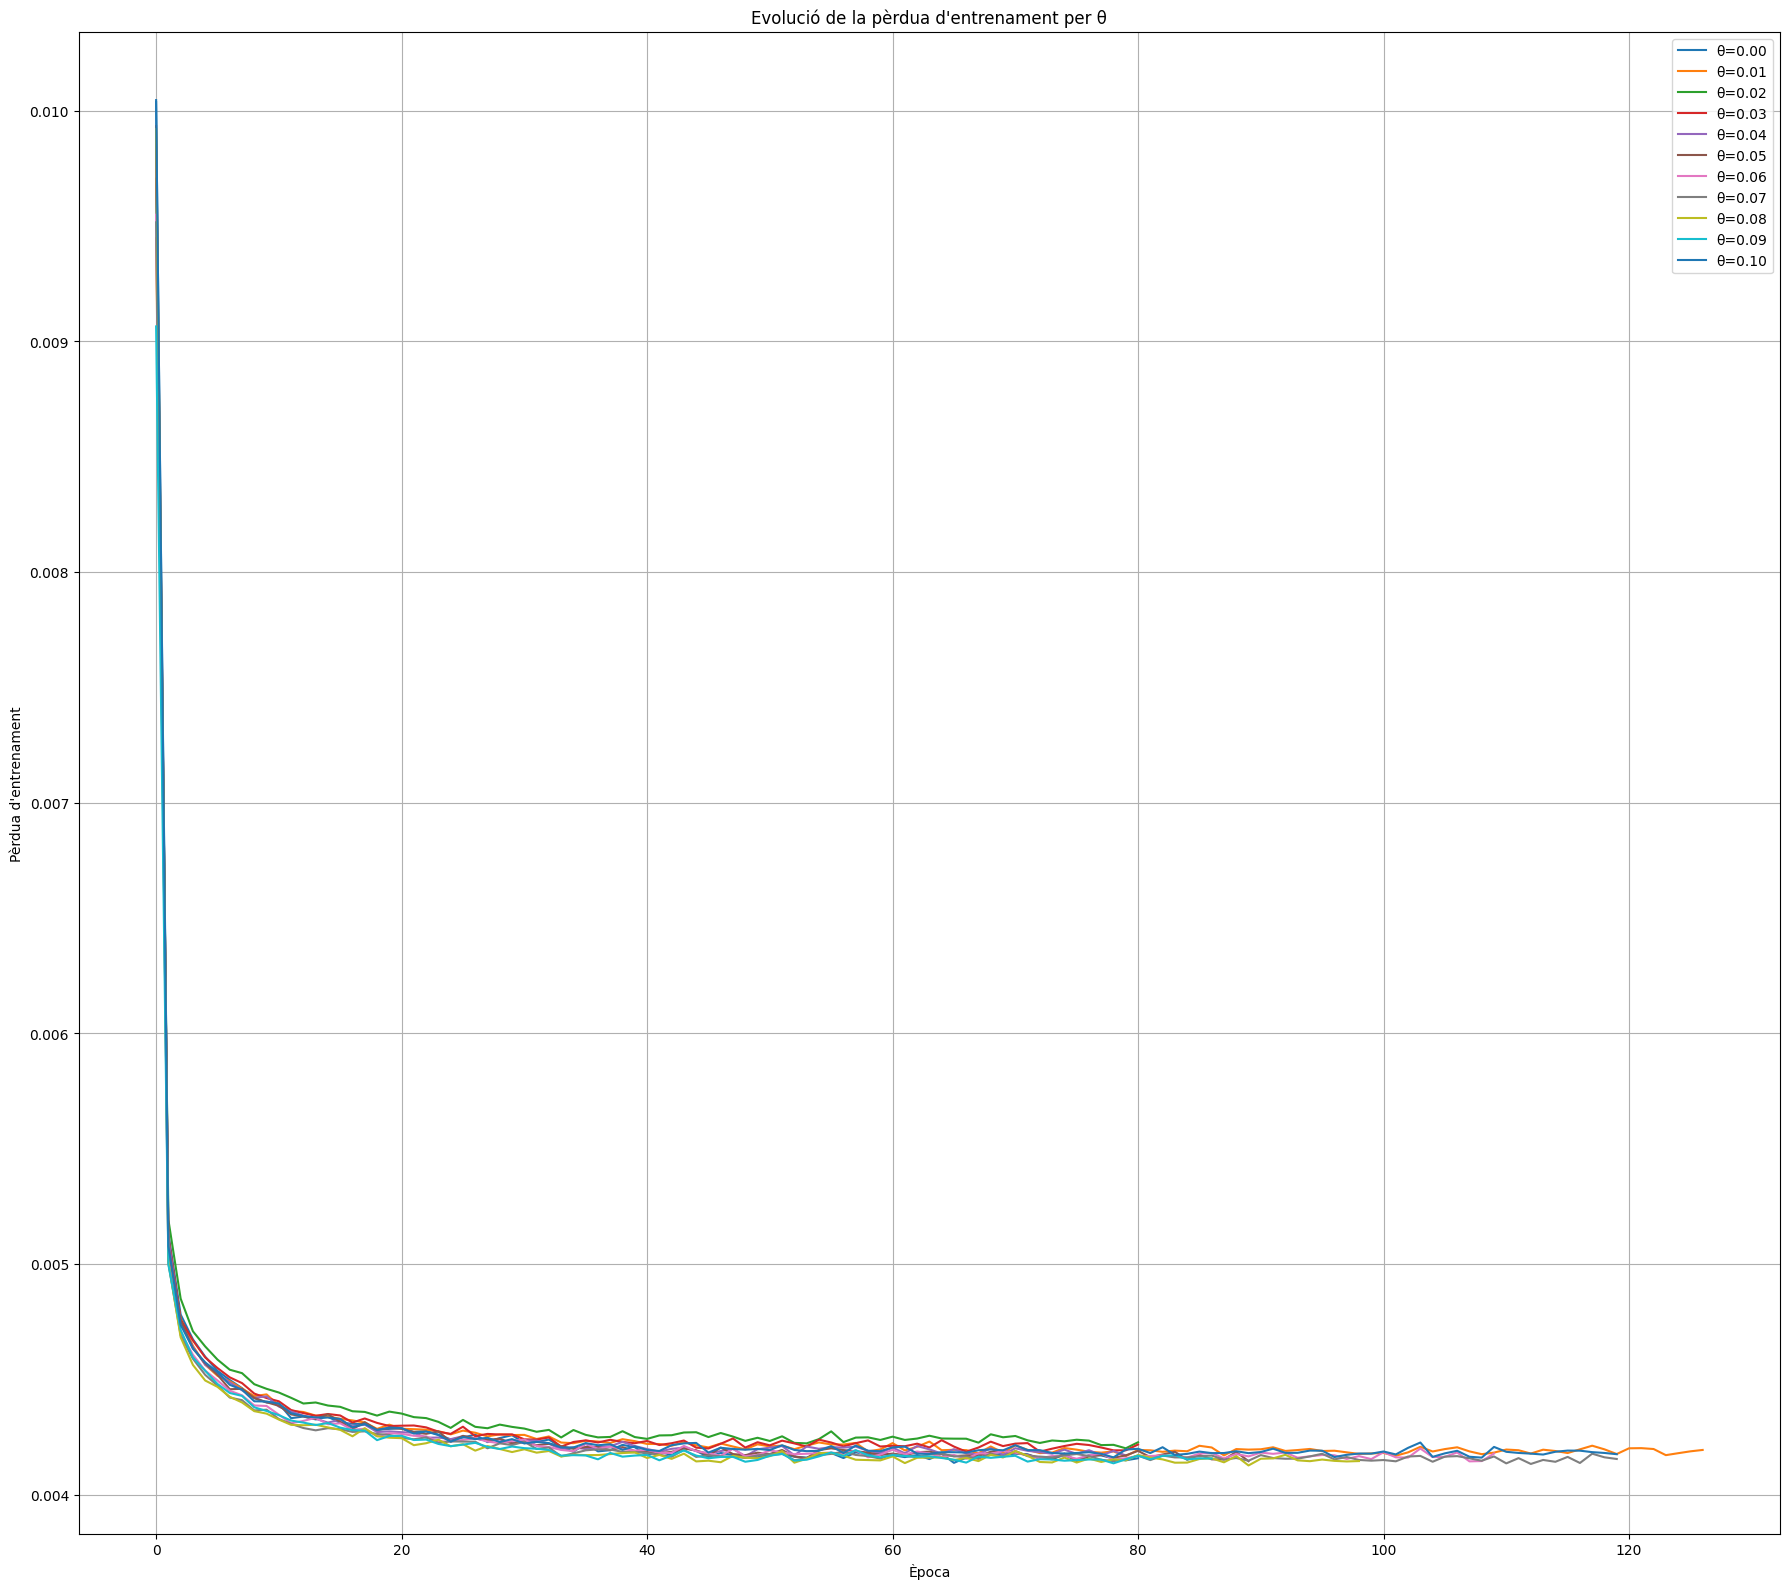

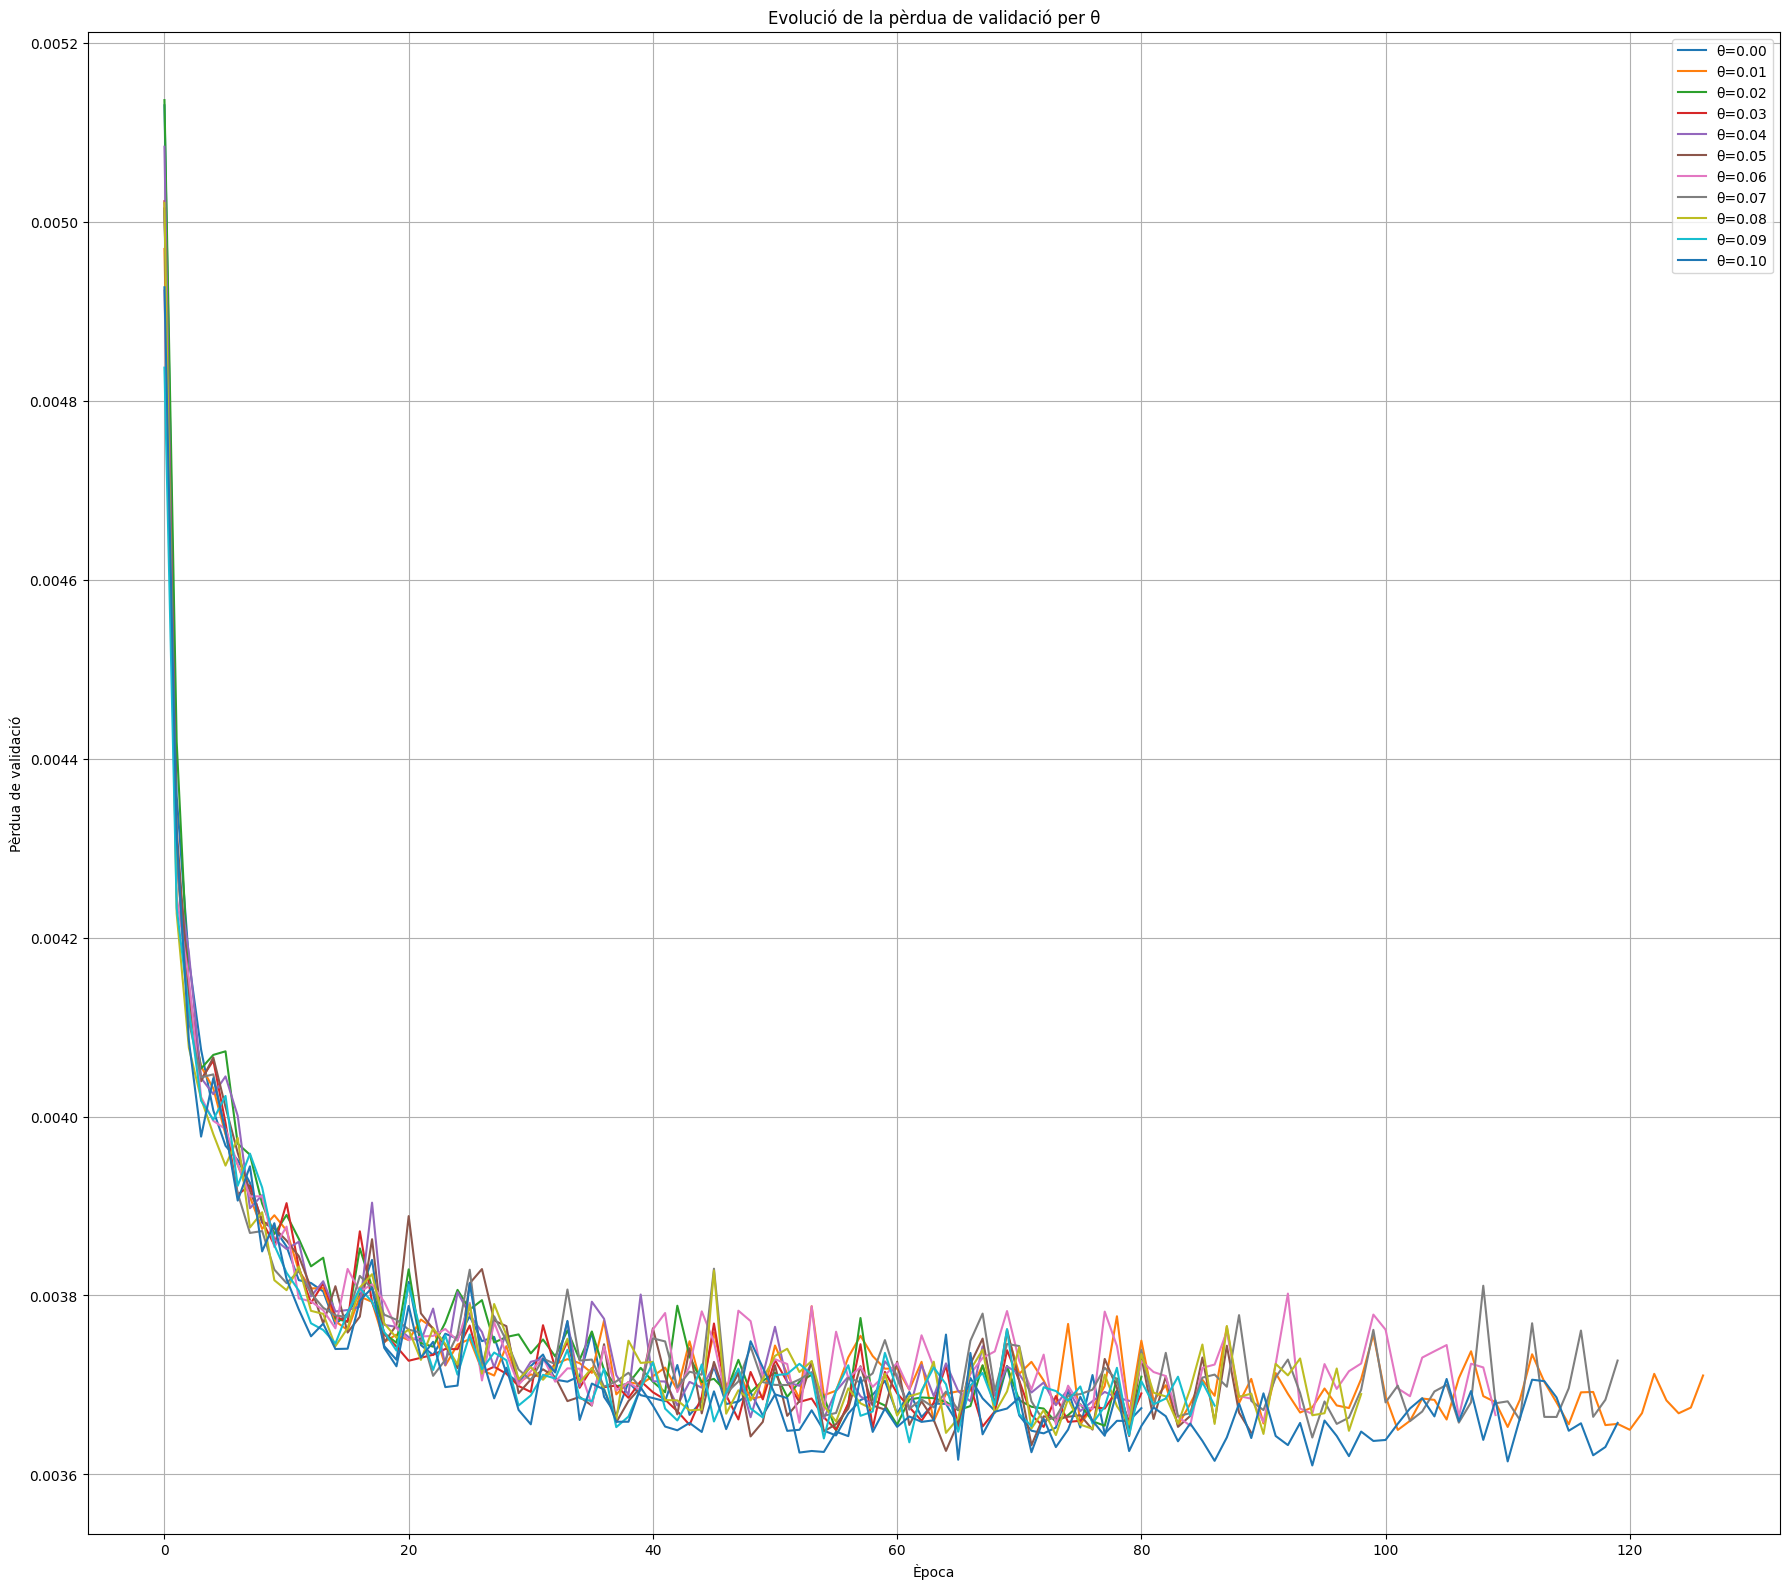

In [22]:
import matplotlib.pyplot as plt

# 1. Evolució de la pèrdua d'entrenament
plt.figure(figsize=(18, 16))
for theta, hist in histories.items():
    plt.plot(hist['loss'], label=f'θ={theta:.2f}')
plt.title("Evolució de la pèrdua d'entrenament per θ")
plt.xlabel("Època")
plt.ylabel("Pèrdua d'entrenament")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("perdua_train_epochs_per_theta.png")
plt.show()

# 2. Evolució de la pèrdua de validació
plt.figure(figsize=(18, 16))
for theta, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'θ={theta:.2f}')
plt.title("Evolució de la pèrdua de validació per θ")
plt.xlabel("Època")
plt.ylabel("Pèrdua de validació")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("perdua_val_epochs_per_theta.png")
plt.show()
